# Parameters

In [34]:
MAX_ROWS        = 100000

HISTOGRAM_COLOR = (0.5,0.5,0.5)
ALL_GRAPH_COLOR = (0.2,0.2,0.2)
OUTPUT_FORMAT   = 'eps'

REPORT_SIZE     = True

FULL_FIG_W , FULL_FIG_H  = (19 if REPORT_SIZE else 16) , 8
CHROM_FIG_W, CHROM_FIG_H = FULL_FIG_W, 20


config = {
    'data_folder': 'probes',
    'RUN'        : 'run_BWA_JKL_23_JU_1_orig',
    'chromosome' : 'SL2.40ch12',
    'scaffold'   : 'SL2.40sc04878',
    'out_folder' : 'reports'
}

if False:
    config['BAC'            ] = 'JBPP0904'
    config['BAC_coord_start'] = 967164
    config['BAC_coord_end'  ] = 970727
    config['BAC_coord'      ] = '%012d-%012d' % ( config['BAC_coord_start'], config['BAC_coord_end'  ] )
    config['RUN'            ] = 'run_BWA_JKL_23_JU_1_orig_PROBES'

    
BAC_MODE     = False
cols_to_plot = [
        # Col name                                 limit     # ticks
        [ "K-mer Coverage"                       , [0,1]   , 5 ], 
        [ "Sequencing Coverage"                  , None    , 5 ],
        [ "Ns"                                   , [0.1,1] , 0 ],
        [ "AGP Contig"                           , [0.1,1] , 0 ],
        [ "AGP Gap"                              , [0.1,1] , 0 ],
        [ "AGP Unknown"                          , [0.1,1] , 0 ],
        [ "AGP Other"                            , [0.1,1] , 0 ],
        [ "K-mer Coverage averaged: 500 bp"      , [0,None], 2 ],
        [ "K-mer Coverage averaged: 2.5 Kbp"     , [0,None], 2 ],
        [ "K-mer Coverage averaged: 5 Kbp"       , [0,None], 2 ],
        [ "K-mer Coverage averaged: 50 Kbp"      , [0,None], 2 ],
        [ "K-mer Coverage averaged: 1 Mbp"       , [0,None], 2 ],
        [ "K-mer Coverage averaged: 5 Kbp before", [0,None], 2 ],
        [ "K-mer Coverage averaged: 5 Kbp after" , [0,None], 2 ]
    ]

if 'BAC' in config:
    BAC_MODE = True
    cols_to_plot.insert(2, ['BLAST Coverage', [0, None], 5 ])

print "Column Names"
for col_to_plot in cols_to_plot:
    print "\t", col_to_plot[0]
    
print "Config"
for cfg in sorted(config.keys()):
    print "\t%-15s: %s" % (cfg, config[cfg])
    
    
## For debugging only
NROWS           = 1000
NROWS           = 10000
NROWS           = None

PARSE_VERBOSE   = False
#PARSE_VERBOSE   = True


Column Names
	K-mer Coverage
	Sequencing Coverage
	Ns
	AGP Contig
	AGP Gap
	AGP Unknown
	AGP Other
	K-mer Coverage averaged: 500 bp
	K-mer Coverage averaged: 2.5 Kbp
	K-mer Coverage averaged: 5 Kbp
	K-mer Coverage averaged: 50 Kbp
	K-mer Coverage averaged: 1 Mbp
	K-mer Coverage averaged: 5 Kbp before
	K-mer Coverage averaged: 5 Kbp after
Config
	RUN            : run_BWA_JKL_23_JU_1_orig
	chromosome     : SL2.40ch12
	data_folder    : probes
	out_folder     : reports
	scaffold       : SL2.40sc04878


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import os
from IPython.display import HTML
import operator

#import pylab
#pylab.show()

%pylab inline

pd.set_option('display.notebook_repr_html', True)
#pd.set_option('display.max_columns', 20)
#pd.set_option('display.max_rows', 25)

def addHeader(level, text):
    display( HTML('''<h%(level)d>%(text)s</h%(level)d>''' % {'level':level, 'text':text}) )

Populating the interactive namespace from numpy and matplotlib


# Constants

## Input Files

In [3]:
"""
S_lycopersicum_chromosomes.fa_S_lycopersicum_scaffolds.sam.SL2.40ch12.sam.SL2.40sc06147.sam.cov
S_lycopersicum_chromosomes.fa_S_lycopersicum_scaffolds.sam.SL2.40ch12.sam.SL2.40sc06147.sam.cov.prop.cov
S_lycopersicum_chromosomes.fa_S_lycopersicum_scaffolds.sam.SL2.40ch12.sam.SL2.40sc06147.sam.pos
"""
    
KmerCoverageFile       = "%(data_folder)s/%(RUN)s/S_lycopersicum_chromosomes.fa_S_lycopersicum_scaffolds.sam.%(chromosome)s.sam.%(scaffold)s.sam.cov.prop.cov" % config
SequencingCoverageFile = "%(data_folder)s/mapping/out/S_lycopersicum_chromosomes.fa_S_lycopersicum_chromosomes.pos.%(chromosome)s.pos.cov.%(scaffold)s.cov"    % config
AgpContigFile          = "%(data_folder)s/agp/S_lycopersicum_scaffolds_from_contigs.2.40.agp.%(scaffold)s.agp.contig.agp.cov"  % config
AgpGapFile             = "%(data_folder)s/agp/S_lycopersicum_scaffolds_from_contigs.2.40.agp.%(scaffold)s.agp.gap.agp.cov"     % config
AgpOtherFile           = "%(data_folder)s/agp/S_lycopersicum_scaffolds_from_contigs.2.40.agp.%(scaffold)s.agp.other.agp.cov"   % config
AgpUnknownFile         = "%(data_folder)s/agp/S_lycopersicum_scaffolds_from_contigs.2.40.agp.%(scaffold)s.agp.unknown.agp.cov" % config
NsFile                 = "%(data_folder)s/Ns/S_lycopersicum_scaffolds.fa_NONE.tab.%(chromosome)s.tab.%(scaffold)s.tab.cov"     % config
infiles                = [KmerCoverageFile, SequencingCoverageFile, 
                          AgpContigFile, AgpGapFile, 
                          AgpUnknownFile, AgpOtherFile, NsFile]

if BAC_MODE:
    """

                                                      S_lycopersicum_chromosomes.fa_S_lycopersicum_scaffolds.sam.SL2.40ch12.SL2.40sc05611.JBPP0904_primer.000000967164-000000970727.S_lycopersicum_chromosomes.fa_S_lycopersicum_chromosomes.pos.SL2.40ch12.pos.cov.SL2.40sc05611.cov
                                                      S_lycopersicum_chromosomes.fa_S_lycopersicum_scaffolds.sam.SL2.40ch12.SL2.40sc05611.JBPP0904_primer.000000967164-000000970727.S_lycopersicum_chromosomes.fa_S_lycopersicum_scaffolds.sam.SL2.40ch12.sam.SL2.40sc05611.sam.cov.prop.cov
                                                      S_lycopersicum_chromosomes.fa_S_lycopersicum_scaffolds.sam.SL2.40ch12.SL2.40sc05611.JBPP0904_primer.000000967164-000000970727_Product.fasta.blast.cov
                                                      S_lycopersicum_chromosomes.fa_S_lycopersicum_scaffolds.sam.SL2.40ch12.SL2.40sc05611.JBPP0904_primer.000000967164-000000970727.S_lycopersicum_scaffolds_from_contigs.2.40.agp.SL2.40sc05611.agp.contig.agp.cov
                                                      S_lycopersicum_chromosomes.fa_S_lycopersicum_scaffolds.sam.SL2.40ch12.SL2.40sc05611.JBPP0904_primer.000000967164-000000970727.S_lycopersicum_scaffolds_from_contigs.2.40.agp.SL2.40sc05611.agp.gap.agp.cov
                                                      S_lycopersicum_chromosomes.fa_S_lycopersicum_scaffolds.sam.SL2.40ch12.SL2.40sc05611.JBPP0904_primer.000000967164-000000970727.S_lycopersicum_scaffolds_from_contigs.2.40.agp.SL2.40sc05611.agp.other.agp.cov
                                                      S_lycopersicum_chromosomes.fa_S_lycopersicum_scaffolds.sam.SL2.40ch12.SL2.40sc05611.JBPP0904_primer.000000967164-000000970727.S_lycopersicum_scaffolds_from_contigs.2.40.agp.SL2.40sc05611.agp.unknown.agp.cov
                                                      S_lycopersicum_chromosomes.fa_S_lycopersicum_scaffolds.sam.SL2.40ch12.SL2.40sc05611.JBPP0904_primer.000000967164-000000970727.S_lycopersicum_scaffolds.fa_NONE.tab.SL2.40ch12.tab.SL2.40sc05611.tab.cov
    """
                                                      
    config['in_base_name'] = "%(data_folder)s/%(RUN)s/S_lycopersicum_chromosomes.fa_S_lycopersicum_scaffolds.sam.%(chromosome)s.%(scaffold)s.%(BAC)s_primer.%(BAC_coord)s" % config
    KmerCoverageFile       =                                                                                                                                      "%(in_base_name)s.S_lycopersicum_chromosomes.fa_S_lycopersicum_scaffolds.sam.%(chromosome)s.sam.%(scaffold)s.sam.cov.prop.cov" % config
    SequencingCoverageFile =                                                                                                                                      "%(in_base_name)s.S_lycopersicum_chromosomes.fa_S_lycopersicum_chromosomes.pos.%(chromosome)s.pos.cov.%(scaffold)s.cov"        % config
    BlastCoverageFile      =                                                                                                                                      "%(in_base_name)s_Product.fasta.blast.cov"                                                         % config
    AgpContigFile          =                                                                                                                                      "%(in_base_name)s.S_lycopersicum_scaffolds_from_contigs.2.40.agp.%(scaffold)s.agp.contig.agp.cov"  % config
    AgpGapFile             =                                                                                                                                      "%(in_base_name)s.S_lycopersicum_scaffolds_from_contigs.2.40.agp.%(scaffold)s.agp.gap.agp.cov"     % config
    AgpOtherFile           =                                                                                                                                      "%(in_base_name)s.S_lycopersicum_scaffolds_from_contigs.2.40.agp.%(scaffold)s.agp.other.agp.cov"   % config
    AgpUnknownFile         =                                                                                                                                      "%(in_base_name)s.S_lycopersicum_scaffolds_from_contigs.2.40.agp.%(scaffold)s.agp.unknown.agp.cov" % config
    NsFile                 =                                                                                                                                      "%(in_base_name)s.S_lycopersicum_scaffolds.fa_NONE.tab.%(chromosome)s.tab.%(scaffold)s.tab.cov"    % config
    
    infiles                = [KmerCoverageFile, SequencingCoverageFile, 
                              BlastCoverageFile, AgpContigFile, 
                              AgpGapFile, AgpUnknownFile, 
                              AgpOtherFile, NsFile]


print "%-22s: %-5s %s" % ( "KmerCoverageFile"      , os.path.exists(KmerCoverageFile)      , KmerCoverageFile       )
print "%-22s: %-5s %s" % ( "SequencingCoverageFile", os.path.exists(SequencingCoverageFile), SequencingCoverageFile )
print "%-22s: %-5s %s" % ( "AgpContigFile"         , os.path.exists(AgpContigFile)         , AgpContigFile          )
print "%-22s: %-5s %s" % ( "AgpGapFile"            , os.path.exists(AgpGapFile)            , AgpGapFile             )
print "%-22s: %-5s %s" % ( "AgpOtherFile"          , os.path.exists(AgpOtherFile)          , AgpOtherFile           )
print "%-22s: %-5s %s" % ( "AgpUnknownFile"        , os.path.exists(AgpUnknownFile)        , AgpUnknownFile         )
print "%-22s: %-5s %s" % ( "NsFile"                , os.path.exists(NsFile)                , NsFile                 )



if BAC_MODE:
    print "%-22s: %-5s %s" % ( "BlastCoverageFile" , os.path.exists(BlastCoverageFile)     , BlastCoverageFile      )

print



if not all([os.path.exists(x) for x in infiles]):
    print "missing file"
    #quit()
else:
    print "all files present"
    

KmerCoverageFile      : True  probes/run_BWA_JKL_23_JU_1_orig/S_lycopersicum_chromosomes.fa_S_lycopersicum_scaffolds.sam.SL2.40ch12.sam.SL2.40sc04878.sam.cov.prop.cov
SequencingCoverageFile: True  probes/mapping/out/S_lycopersicum_chromosomes.fa_S_lycopersicum_chromosomes.pos.SL2.40ch12.pos.cov.SL2.40sc04878.cov
AgpContigFile         : True  probes/agp/S_lycopersicum_scaffolds_from_contigs.2.40.agp.SL2.40sc04878.agp.contig.agp.cov
AgpGapFile            : True  probes/agp/S_lycopersicum_scaffolds_from_contigs.2.40.agp.SL2.40sc04878.agp.gap.agp.cov
AgpOtherFile          : True  probes/agp/S_lycopersicum_scaffolds_from_contigs.2.40.agp.SL2.40sc04878.agp.other.agp.cov
AgpUnknownFile        : True  probes/agp/S_lycopersicum_scaffolds_from_contigs.2.40.agp.SL2.40sc04878.agp.unknown.agp.cov
NsFile                : True  probes/Ns/S_lycopersicum_scaffolds.fa_NONE.tab.SL2.40ch12.tab.SL2.40sc04878.tab.cov

all files present


## Output Files

In [4]:
config['out_extension'] = OUTPUT_FORMAT
config['out_bn'       ] = "%(out_folder)s/%(out_extension)s/%(RUN)s_%(chromosome)s_%(scaffold)s_prop" % config
config['out_bn_img'   ] = "%(out_bn)s.%%s.%(out_extension)s"                                          % config

if BAC_MODE:
    config['out_bn'       ] = "%(out_folder)s/%(out_extension)s/%(RUN)s_%(chromosome)s_%(scaffold)s_%(BAC)s_%(BAC_coord)s" % config
    config['out_bn_img'   ] = "%(out_bn)s.%%s.%(out_extension)s"                                          % config



output_files = {
    'all_data'                        : '%(out_bn)s.csv'      % config,
    'all_data_full'                   : '%(out_bn)s_full.csv' % config,
    'K-mer Coverage Stats'            : config['out_bn_img']  % 'K-mer_Coverage_Stats',
    'Sequencing Coverage Stats'       : config['out_bn_img']  % 'Sequencing_Coverage_Stats',
    'K-mer Coverage Distribution'     : config['out_bn_img']  % 'K-mer_Coverage_Distribution',
    'Sequencing Coverage Distribution': config['out_bn_img']  % 'Sequencing_Coverage_Distribution',
    'Gaps Distribution'               : config['out_bn_img']  % 'Gaps_Distribution',
    'Ns Distribution'                 : config['out_bn_img']  % 'Ns_Distribution',
    'Combined graph'                  : config['out_bn_img']  % 'Combined_graph'
}


if BAC_MODE:
    output_files['BLAST Coverage Stats'       ] = config['out_bn_img'] % 'BLAST_Coverage_Stats'
    output_files['BLAST Coverage Distribution'] = config['out_bn_img'] % 'BLAST_Coverage_Distribution'

    
for of in sorted(output_files.keys()):
    print "%-32s: %s" % ( of, output_files[of] )

Combined graph                  : reports/eps/run_BWA_JKL_23_JU_1_orig_SL2.40ch12_SL2.40sc04878_prop.Combined_graph.eps
Gaps Distribution               : reports/eps/run_BWA_JKL_23_JU_1_orig_SL2.40ch12_SL2.40sc04878_prop.Gaps_Distribution.eps
K-mer Coverage Distribution     : reports/eps/run_BWA_JKL_23_JU_1_orig_SL2.40ch12_SL2.40sc04878_prop.K-mer_Coverage_Distribution.eps
K-mer Coverage Stats            : reports/eps/run_BWA_JKL_23_JU_1_orig_SL2.40ch12_SL2.40sc04878_prop.K-mer_Coverage_Stats.eps
Ns Distribution                 : reports/eps/run_BWA_JKL_23_JU_1_orig_SL2.40ch12_SL2.40sc04878_prop.Ns_Distribution.eps
Sequencing Coverage Distribution: reports/eps/run_BWA_JKL_23_JU_1_orig_SL2.40ch12_SL2.40sc04878_prop.Sequencing_Coverage_Distribution.eps
Sequencing Coverage Stats       : reports/eps/run_BWA_JKL_23_JU_1_orig_SL2.40ch12_SL2.40sc04878_prop.Sequencing_Coverage_Stats.eps
all_data                        : reports/eps/run_BWA_JKL_23_JU_1_orig_SL2.40ch12_SL2.40sc04878_prop.csv
all

In [5]:
class size_controller(object):
    def __init__(self, w, h):
        self.w = w
        self.h = h
        
    def __enter__(self):
        self.o = rcParams['figure.figsize']
        rcParams['figure.figsize'] = self.w, self.h
        return None
    
    def __exit__(self, type, value, traceback):
        rcParams['figure.figsize'] = self.o
        
col_type_int  = np.int64
col_type_flo  = np.float64
col_type_str  = np.object
col_type_bol  = np.int8

# Read Files

## K-mer Coverage File

In [6]:
col_info = [
    [ "Position"                             , col_type_int ], 
    [ "K-mer Coverage"                       , col_type_flo ], 
    [ "K-mer Coverage averaged: 500 bp"      , col_type_flo ], 
    [ "K-mer Coverage averaged: 2.5 Kbp"     , col_type_flo ], 
    [ "K-mer Coverage averaged: 5 Kbp"       , col_type_flo ], 
    [ "K-mer Coverage averaged: 50 Kbp"      , col_type_flo ], 
    [ "K-mer Coverage averaged: 1 Mbp"       , col_type_flo ], 
    [ "K-mer Coverage averaged: 5 Kbp before", col_type_flo ], 
    [ "K-mer Coverage averaged: 5 Kbp after" , col_type_flo ]
]

col_names=[cf[0] for cf in col_info]
col_types=dict(zip([c[0] for c in col_info], [c[1] for c in col_info]))

if PARSE_VERBOSE:
    print "\n".join( col_names )

In [7]:
SKIP_ROWS = 1

print KmerCoverageFile

KmerData  = pd.read_csv(KmerCoverageFile, header=None, names=col_names, dtype=col_types, nrows=NROWS, \
                        skiprows=SKIP_ROWS, verbose=PARSE_VERBOSE, delimiter="\t", comment="#")
    
print "Loaded %d rows and %d columns" % ( KmerData.shape[0], KmerData.shape[1] )

if PARSE_VERBOSE:
    print KmerData.head()

probes/run_BWA_JKL_23_JU_1_orig/S_lycopersicum_chromosomes.fa_S_lycopersicum_scaffolds.sam.SL2.40ch12.sam.SL2.40sc04878.sam.cov.prop.cov
Loaded 5717763 rows and 9 columns


## Sequencing Coverage File

In [8]:
col_info = [
    [ "Position"                             , col_type_int ], 
    [ "Sequencing Coverage"                  , col_type_int ]
]

col_names=[cf[0] for cf in col_info]
col_types=dict(zip([c[0] for c in col_info], [c[1] for c in col_info]))

if PARSE_VERBOSE:
    print col_names
    col_types

In [9]:
SKIP_ROWS = 0

print SequencingCoverageFile

SequencingCoverageData  = pd.read_csv(SequencingCoverageFile, header=None, names=col_names, dtype=col_types, nrows=NROWS, \
                        skiprows=SKIP_ROWS, verbose=PARSE_VERBOSE, delimiter="\t", comment="#")

print "Loaded %d rows and %d columns" % ( SequencingCoverageData.shape[0], SequencingCoverageData.shape[1] )

if PARSE_VERBOSE:
    print SequencingCoverageData.head()

probes/mapping/out/S_lycopersicum_chromosomes.fa_S_lycopersicum_chromosomes.pos.SL2.40ch12.pos.cov.SL2.40sc04878.cov
Loaded 5717763 rows and 2 columns


In [10]:
if BAC_MODE:
    addHeader(1,'BLAST')

    col_info = [
        [ "Position"                             , col_type_int ], 
        [ "BLAST Coverage"                       , col_type_flo ]
    ]

    col_names=[cf[0] for cf in col_info]
    col_types=dict(zip([c[0] for c in col_info], [c[1] for c in col_info]))

    if PARSE_VERBOSE:
        print col_names
        col_types

In [11]:
if BAC_MODE:
    SKIP_ROWS = 0
    
    print BlastCoverageFile
    
    BlastCoverageData  = pd.read_csv(BlastCoverageFile, header=None, names=col_names, dtype=col_types, nrows=NROWS, \
                            skiprows=SKIP_ROWS, verbose=PARSE_VERBOSE, delimiter="\t", comment="#")
        
    print "Loaded %d rows and %d columns" % ( BlastCoverageData.shape[0], BlastCoverageData.shape[1] )
    
    if PARSE_VERBOSE:
        print BlastCoverageData.head()

##AGP

In [12]:
SKIP_ROWS = 0

### Contig

In [13]:
col_info = [
    [ "Position"                    , col_type_int ], 
    [ "AGP Contig"                  , col_type_bol ]
]

col_names=[cf[0] for cf in col_info]
col_types=dict(zip([c[0] for c in col_info], [c[1] for c in col_info]))

if PARSE_VERBOSE:
    print col_names
    col_types

In [14]:
print AgpContigFile

AgpContigData  = pd.read_csv(AgpContigFile, header=None, names=col_names, dtype=col_types, nrows=NROWS, \
                        skiprows=SKIP_ROWS, verbose=PARSE_VERBOSE, delimiter="\t", comment="#")

print "Loaded %d rows and %d columns" % ( AgpContigData.shape[0], AgpContigData.shape[1] )

if PARSE_VERBOSE:
    print AgpContigData.head()

probes/agp/S_lycopersicum_scaffolds_from_contigs.2.40.agp.SL2.40sc04878.agp.contig.agp.cov
Loaded 5717763 rows and 2 columns


### Gap

In [15]:
col_info = [
    [ "Position"                    , col_type_int ], 
    [ "AGP Gap"                     , col_type_bol ]
]

col_names=[cf[0] for cf in col_info]
col_types=dict(zip([c[0] for c in col_info], [c[1] for c in col_info]))

if PARSE_VERBOSE:
    print col_names
    col_types

In [16]:
print AgpGapFile

AgpGapData  = pd.read_csv(AgpGapFile, header=None, names=col_names, dtype=col_types, nrows=NROWS, \
                        skiprows=SKIP_ROWS, verbose=PARSE_VERBOSE, delimiter="\t", comment="#")
    
print "Loaded %d rows and %d columns" % ( AgpGapData.shape[0], AgpGapData.shape[1] )

if PARSE_VERBOSE:
    print AgpGapData.head()

probes/agp/S_lycopersicum_scaffolds_from_contigs.2.40.agp.SL2.40sc04878.agp.gap.agp.cov
Loaded 5717763 rows and 2 columns


### Unknown

In [17]:
col_info = [
    [ "Position"                    , col_type_int ], 
    [ "AGP Unknown"                 , col_type_bol ]
]

col_names=[cf[0] for cf in col_info]
col_types=dict(zip([c[0] for c in col_info], [c[1] for c in col_info]))

if PARSE_VERBOSE:
    print col_names
    col_types

In [18]:
print AgpUnknownFile

AgpUnknownData  = pd.read_csv(AgpUnknownFile, header=None, names=col_names, dtype=col_types, nrows=NROWS, \
                        skiprows=SKIP_ROWS, verbose=PARSE_VERBOSE, delimiter="\t", comment="#")
    
print "Loaded %d rows and %d columns" % ( AgpUnknownData.shape[0], AgpUnknownData.shape[1] )

if PARSE_VERBOSE:
    print AgpUnknownData.head()

probes/agp/S_lycopersicum_scaffolds_from_contigs.2.40.agp.SL2.40sc04878.agp.unknown.agp.cov
Loaded 5717763 rows and 2 columns


### Other

In [19]:
col_info = [
    [ "Position"                    , col_type_int ], 
    [ "AGP Other"                   , col_type_bol ]
]

col_names=[cf[0] for cf in col_info]
col_types=dict(zip([c[0] for c in col_info], [c[1] for c in col_info]))

if PARSE_VERBOSE:
    print col_names
    col_types

In [20]:
print AgpOtherFile

AgpOtherData  = pd.read_csv(AgpOtherFile, header=None, names=col_names, dtype=col_types, nrows=NROWS, \
                        skiprows=SKIP_ROWS, verbose=PARSE_VERBOSE, delimiter="\t", comment="#")

print "Loaded %d rows and %d columns" % ( AgpOtherData.shape[0], AgpOtherData.shape[1] )

if PARSE_VERBOSE:
    print AgpOtherData.head()

probes/agp/S_lycopersicum_scaffolds_from_contigs.2.40.agp.SL2.40sc04878.agp.other.agp.cov
Loaded 5717763 rows and 2 columns


## Ns

In [21]:
col_info = [
    [ "Position"                    , col_type_int ], 
    [ "Ns"                          , col_type_bol ]
]

col_names=[cf[0] for cf in col_info]
col_types=dict(zip([c[0] for c in col_info], [c[1] for c in col_info]))

if PARSE_VERBOSE:
    print col_names
    col_types

In [22]:
print NsFile

NsData  = pd.read_csv(NsFile, header=None, names=col_names, dtype=col_types, nrows=NROWS, \
                        skiprows=SKIP_ROWS, verbose=PARSE_VERBOSE, delimiter="\t", comment="#")
    
print "Loaded %d rows and %d columns" % ( NsData.shape[0], NsData.shape[1] )

if PARSE_VERBOSE:
    print NsData.head()

probes/Ns/S_lycopersicum_scaffolds.fa_NONE.tab.SL2.40ch12.tab.SL2.40sc04878.tab.cov
Loaded 5717763 rows and 2 columns


# Merge

In [23]:
Data = pd.DataFrame(KmerData, copy=True)

Data.combine_first( KmerData )
Data["AGP Contig"         ] = AgpContigData[         "AGP Contig"         ]
Data["AGP Gap"            ] = AgpGapData[            "AGP Gap"            ]
Data["AGP Unknown"        ] = AgpUnknownData[        "AGP Unknown"        ]
Data["AGP Other"          ] = AgpOtherData[          "AGP Other"          ]
Data["Ns"                 ] = NsData[                "Ns"                 ]
Data["Sequencing Coverage"] = SequencingCoverageData["Sequencing Coverage"]
if BAC_MODE:
    Data["BLAST Coverage" ] = BlastCoverageData[     "BLAST Coverage"     ]

print "Saved %d rows and %d columns" % ( Data.shape[0], Data.shape[1] )

if PARSE_VERBOSE:
    print Data.head()

Saved 5717763 rows and 15 columns


# Pot

## K-mer Coverage Stats

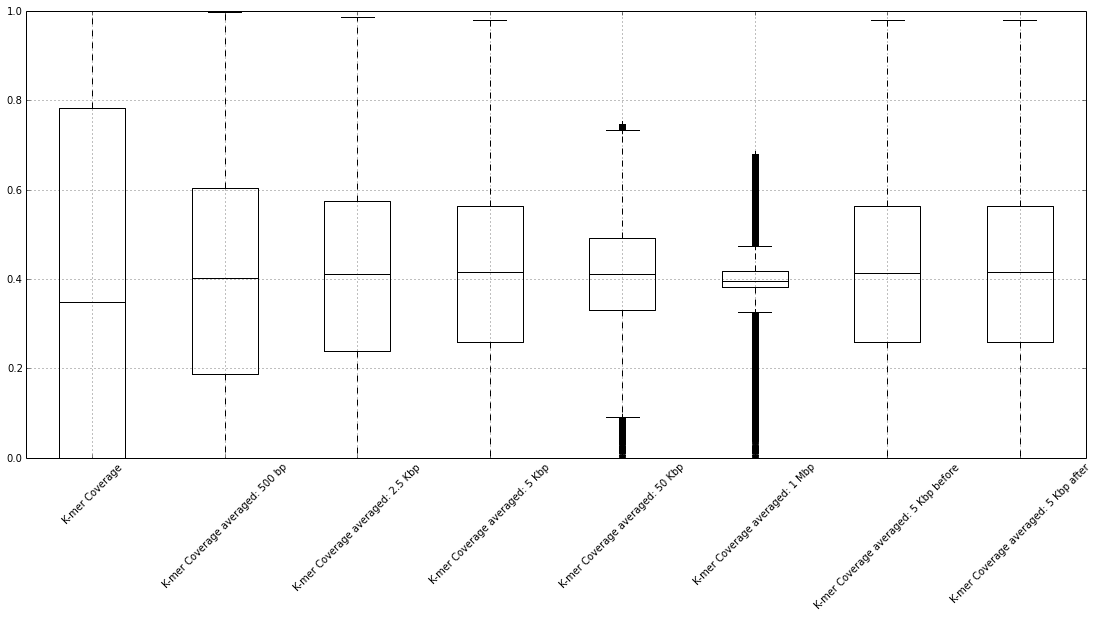

In [24]:
with size_controller(FULL_FIG_W, FULL_FIG_H):
    bqc = Data.boxplot(column=["K-mer Coverage", 
                               "K-mer Coverage averaged: 500 bp",
                               "K-mer Coverage averaged: 2.5 Kbp",
                               "K-mer Coverage averaged: 5 Kbp",
                               "K-mer Coverage averaged: 50 Kbp",
                               "K-mer Coverage averaged: 1 Mbp",
                               "K-mer Coverage averaged: 5 Kbp before",
                               "K-mer Coverage averaged: 5 Kbp after"], return_type='dict', rot=45)
    plt.setp(bqc['boxes'   ], color='black')
    plt.setp(bqc['medians' ], color='black')
    plt.setp(bqc['whiskers'], color='black')
    plt.setp(bqc['fliers'  ], color='black')
    
    savefig(output_files['K-mer Coverage Stats'])

## Sequencing Coverage Stats

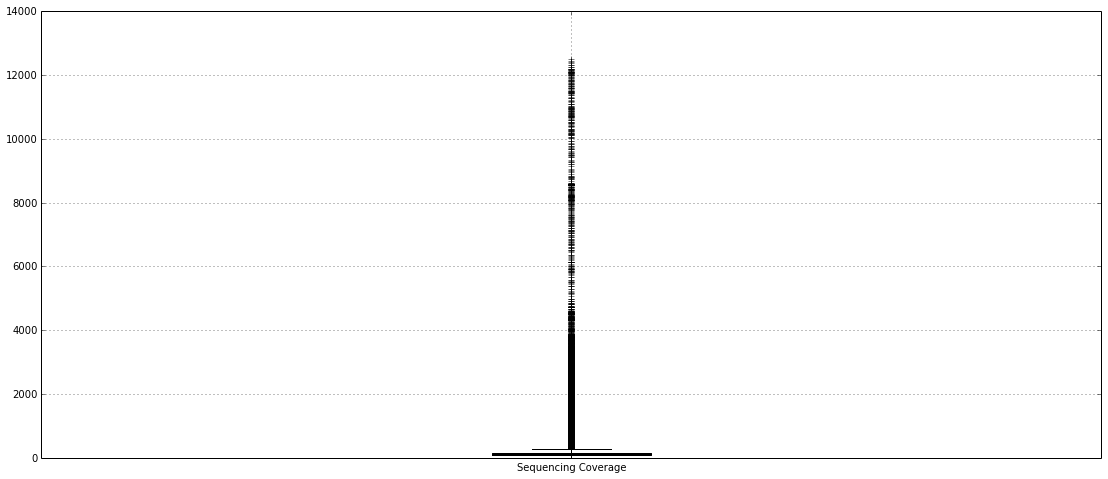

In [25]:
with size_controller(FULL_FIG_W, FULL_FIG_H):
    bqc = Data.boxplot(column=['Sequencing Coverage'], return_type='dict')
    plt.setp(bqc['boxes'   ], color='black')
    plt.setp(bqc['medians' ], color='black')
    plt.setp(bqc['whiskers'], color='black')
    plt.setp(bqc['fliers'  ], color='black')
    savefig(output_files['Sequencing Coverage Stats'])

In [26]:
if BAC_MODE:
    addHeader(2,'BLAST Coverage Stats')
    
    with size_controller(FULL_FIG_W, FULL_FIG_H):
        bqc = Data.boxplot(column=['BLAST Coverage'], return_type='dict')
        plt.setp(bqc['boxes'   ], color='black')
        plt.setp(bqc['medians' ], color='black')
        plt.setp(bqc['whiskers'], color='black')
        plt.setp(bqc['fliers'  ], color='black')
        savefig(output_files['BLAST Coverage Stats'])

## K-mer Coverage Distribution

3743704


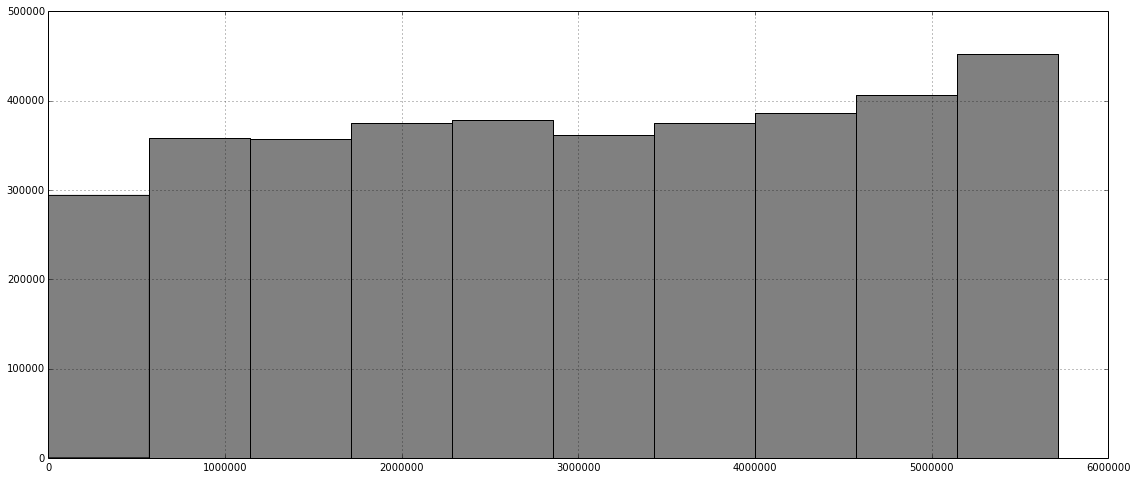

In [27]:
with size_controller(FULL_FIG_W, FULL_FIG_H):
    hf = Data[ Data["K-mer Coverage"] > 0 ]['Position']
    print hf.size
    if hf.size > 0:
        hs = hf.hist(color=HISTOGRAM_COLOR)
        savefig(output_files['K-mer Coverage Distribution'])

## Sequencing Coverage Distribution

5452930


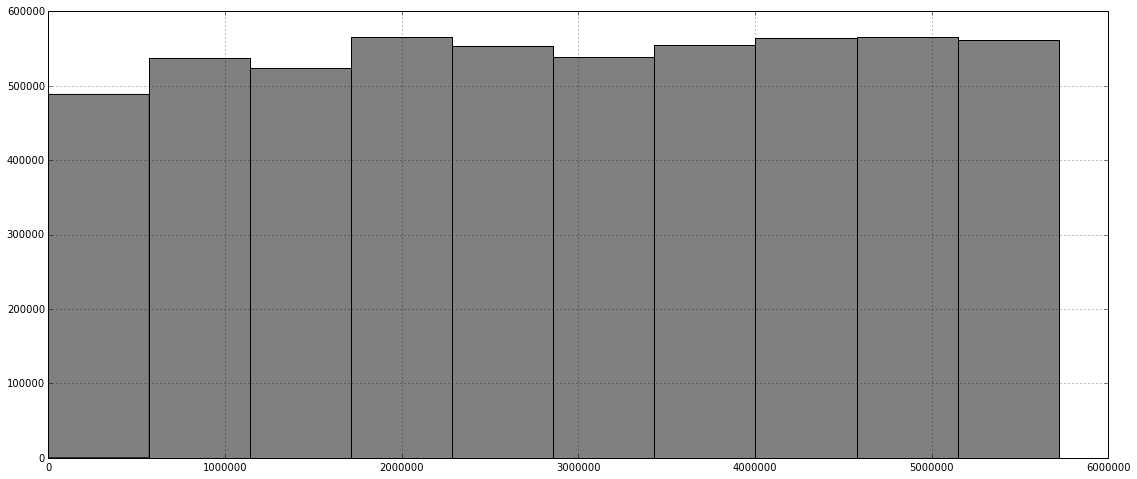

In [28]:
with size_controller(FULL_FIG_W, FULL_FIG_H):
    hf = Data[ Data["Sequencing Coverage"] > 0 ]['Position']
    print hf.size
    if hf.size > 0:
        hs = hf.hist(color=HISTOGRAM_COLOR)
        savefig(output_files['Sequencing Coverage Distribution'])

In [29]:
if BAC_MODE:
    addHeader(2,'BLAST Coverage Distribution')
    
    with size_controller(FULL_FIG_W, FULL_FIG_H):
        hf = Data[ Data["BLAST Coverage"] > 0 ]['Position']
        print hf.size
        if hf.size > 0:
            hs = hf.hist(color=HISTOGRAM_COLOR)
            savefig(output_files['BLAST Coverage Distribution'])

## Gaps Distribution

328216


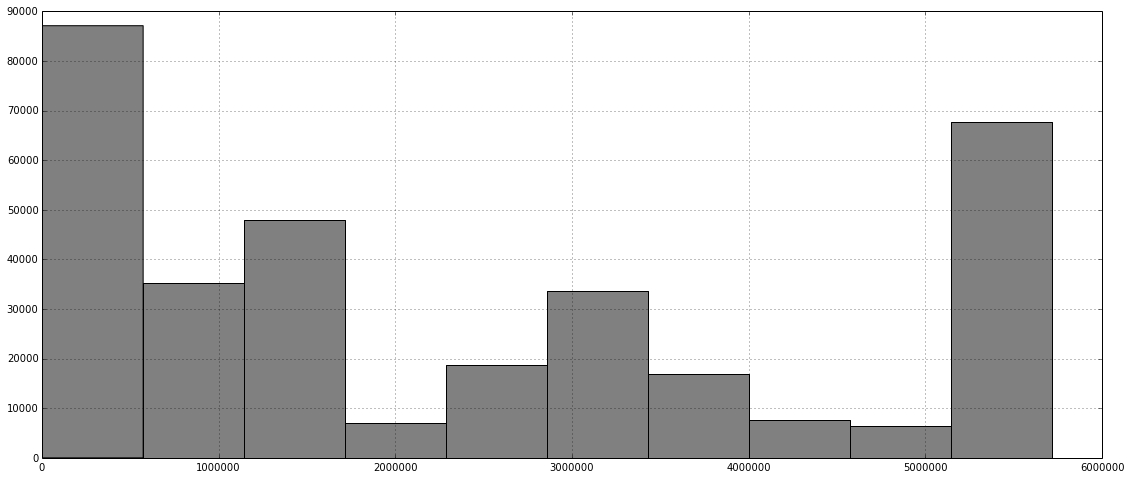

In [30]:
with size_controller(FULL_FIG_W, FULL_FIG_H):
    hf = Data[ Data["AGP Gap"] > 0 ]['Position']
    print hf.size
    if hf.size > 0:
        hs = hf.hist(color=HISTOGRAM_COLOR)
        savefig(output_files['Gaps Distribution'])

## Ns Distribution

271199


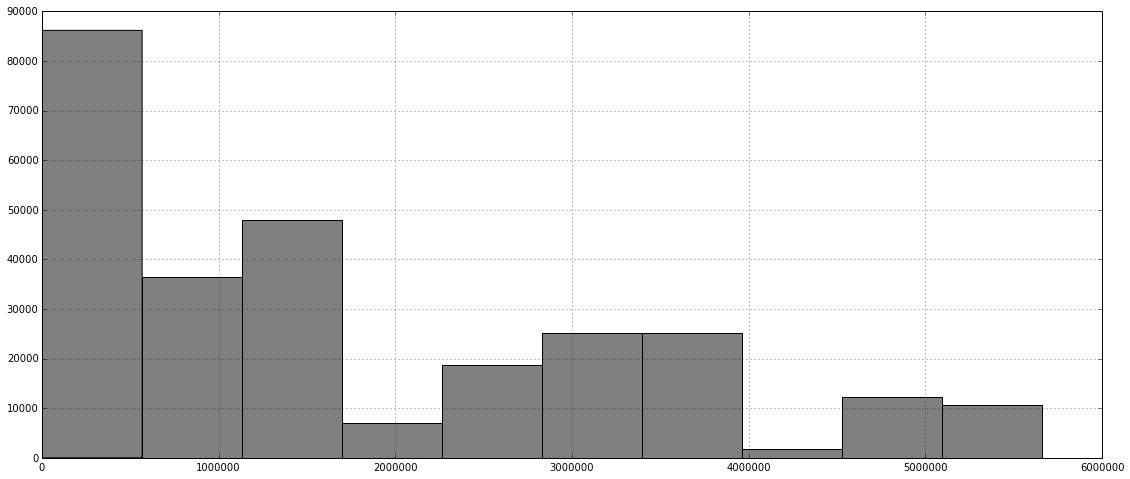

In [31]:
with size_controller(FULL_FIG_W, FULL_FIG_H):
    hf = Data[ Data["Ns"] > 0 ]['Position']
    print hf.size
    if hf.size > 0:
        hs = hf.hist(color=HISTOGRAM_COLOR)
        savefig(output_files['Ns Distribution'])

# CSV output

In [35]:
SAMPLE_EVERY = 1

while ( Data.shape[0] / SAMPLE_EVERY ) > MAX_ROWS:
    SAMPLE_EVERY += 1
    
print "Original Size %d rows and %d columns" % ( Data.shape[0], Data.shape[1] )

if SAMPLE_EVERY != 1:
    print "SAMPLING EVERY %d ROWS" % SAMPLE_EVERY
    
    print "Saving full data to: ", output_files['all_data_full']
    
    Data.to_csv(output_files['all_data_full'], sep='\t', index=False)
    
    DataSampled = Data[::SAMPLE_EVERY]

    print "New Size %d rows and %d columns" % ( Data.shape[0], Data.shape[1] )
    
    if PARSE_VERBOSE:
        print Data.head()

else:
    print "no need to sample"
    DataSampled = Data

print "Saving data to     :", output_files['all_data']
DataSampled.to_csv(output_files['all_data'], sep='\t', index=False)

Original Size 5717763 rows and 15 columns
SAMPLING EVERY 58 ROWS
Saving full data to:  reports/eps/run_BWA_JKL_23_JU_1_orig_SL2.40ch12_SL2.40sc04878_prop_full.csv
New Size 5717763 rows and 15 columns
Saving data to     : reports/eps/run_BWA_JKL_23_JU_1_orig_SL2.40ch12_SL2.40sc04878_prop.csv


# Combined graph

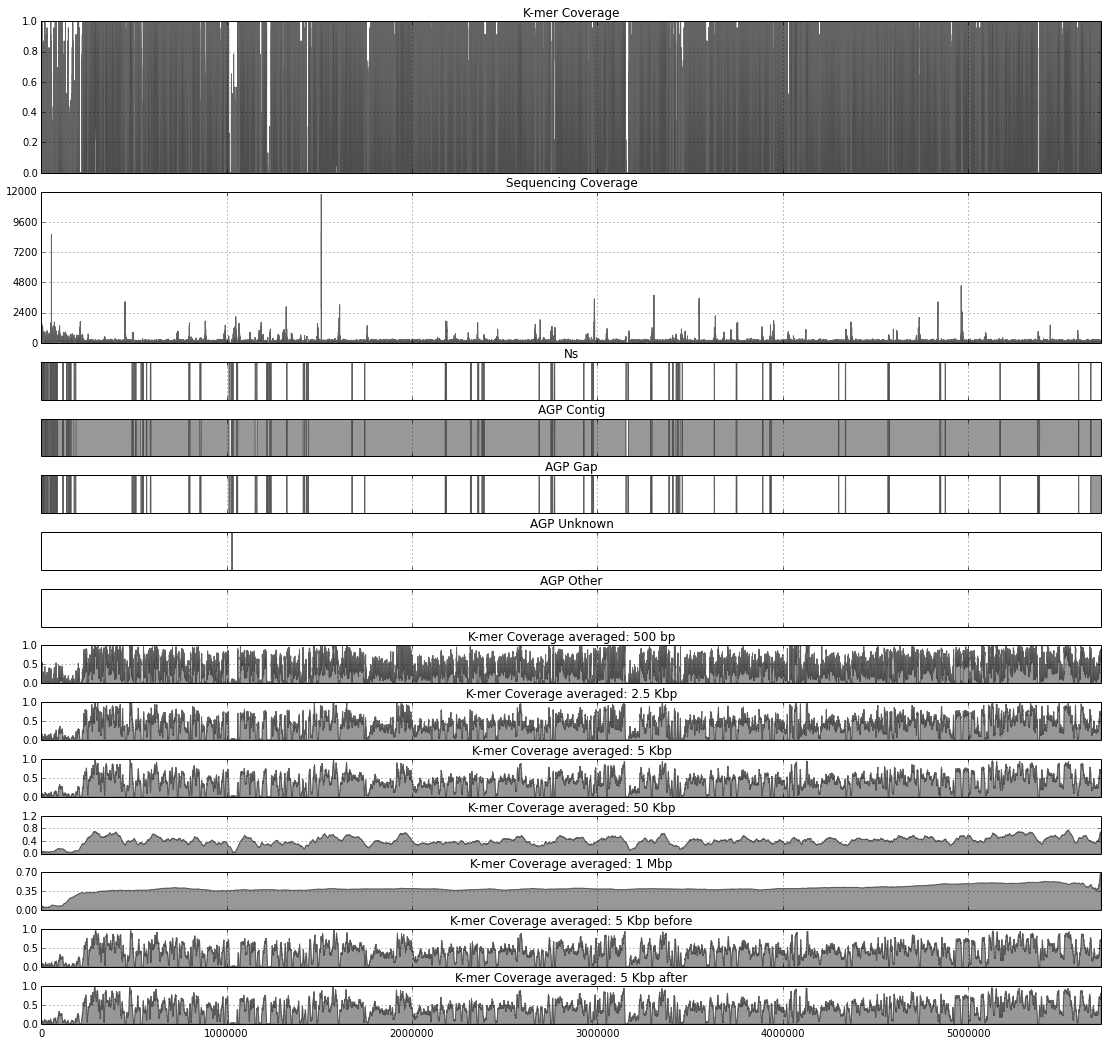

In [36]:
num_cols = len(cols_to_plot)

with size_controller(CHROM_FIG_W, CHROM_FIG_H):
    if True:
        #fig, axes = plt.subplots(nrows=len(cols_to_plot)+2, ncols=1)
        plt.subplots_adjust(wspace=0.5, hspace=0.5)

        num_extra_rows = 2
        num_row_span   = 3
        
        if BAC_MODE:
            num_extra_rows = 3
            num_row_span   = 3
        
        num_cols_e     = num_cols + (num_extra_rows*num_row_span)
        axes           = []

        axes.append( plt.subplot2grid((num_cols_e,1), (0           , 0), rowspan=num_row_span) )
        axes.append( plt.subplot2grid((num_cols_e,1), (num_row_span, 0), rowspan=num_row_span) )
        
        
        if BAC_MODE:
            axes.append( plt.subplot2grid((num_cols_e,1), (num_row_span*2, 0), rowspan=num_row_span) )

            
        for i in xrange ( num_cols - num_extra_rows ):
            axes.append( plt.subplot2grid((num_cols_e,1), ((num_extra_rows*num_row_span)+i, 0) ) )

            
        for col_to_plot_i, col_to_plot_info in enumerate(cols_to_plot):
            col_to_plot, col_ylim, col_yticks = col_to_plot_info
            
            axis = axes[col_to_plot_i]
            DataSampled[col_to_plot].plot(ax=axis, kind='area', stacked=False, color=ALL_GRAPH_COLOR)
            axis.set_title(col_to_plot)
            
            
            if col_ylim is not None:
                col_ylim_min, col_ylim_max = col_ylim
                
                if col_ylim_min is not None:
                    axis.set_ylim( bottom = col_ylim_min )
                
                if col_ylim_max is not None:
                    axis.set_ylim( top    = col_ylim_max )
            
            
            if col_yticks is not None:
                if col_yticks == 0:
                    axis.set_yticks([])
                    
                else:
                    ylim_min, ylim_max = axis.get_ylim()
                    ylim_diff = ylim_max - ylim_min
                    ylim_step = ylim_diff / (col_yticks*1.0)
                    #print col_to_plot, ylim_min, ylim_max, ylim_diff, ylim_step
                    axis.set_yticks(np.arange(ylim_min,ylim_max+ylim_step,ylim_step))
    savefig(output_files['Combined graph'])

In [ ]:
#%install_ext https://raw.githubusercontent.com/rasbt/python_reference/master/ipython_magic/watermark.py
%reload_ext watermark
%watermark --author "Saulo Aflitos" --date --updated --python --hostname --machine --githash --packages numpy,scipy,matplotlib,pandas,IPython

In [37]:
#http://stackoverflow.com/questions/27934885/how-to-hide-code-from-cells-in-ipython-notebook-visualized-with-nbviewer
#from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 var classes_to_hide = ['div.input', 'div.output_stderr', 'div.output_prompt', 'div.input_prompt', 'div.prompt'];
 if (code_show){
    for ( var c in classes_to_hide ) {
        $(classes_to_hide[c]).hide();
        $(classes_to_hide[c]).css('visibility', 'hidden');
    }
 } else {
    for ( var c in classes_to_hide ) {
         $(classes_to_hide[c]).show();
         $(classes_to_hide[c]).css('visibility', 'visible');
    }
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')